# Clasificación de Señales PCG utilizando la red pre-entrenada ResNet152

## Importar Librerías

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import zipfile
import io
from google.colab import files
plt.style.use('seaborn-white')
plt.rcParams.update({'font.size':18})
!pip install -q scikit-plot
import scikitplot as skplt

## Cargar Datos

In [5]:
uploaded = files.upload()
data = zipfile.ZipFile(io.BytesIO(uploaded['Datasets.zip']), 'r')
data.extractall()

Saving Datasets.zip to Datasets.zip


In [6]:
data_transforms = {
    'train':transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Scalograms

In [7]:
image_datasets = {x: datasets.ImageFolder(x, data_transforms[x])
                      for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True,
                                              num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Visualización

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(12, 12))
    plt.imshow(inp, aspect='equal')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Escalogramas

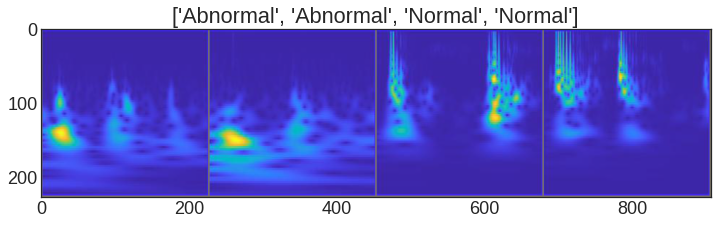

In [10]:
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Entrenamiento de los modelos



### Funciones de entrenamiento y visualización

In [11]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    training_cost = []
    training_acc = []
    validation_cost = []
    validation_acc = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)
        # Cada época tiene una etapa de entrenamiento y de validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Poner el modelo en modo entrenamiento
            else:
                model.eval()   # Poner el modelo en modo evaluación
            running_loss = 0.0
            running_corrects = 0
            # Iterar sobre los datos
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Reiniciar el gradiente
                optimizer.zero_grad()
                # forward
                # habilitar los gradientes solo en la fase de entrenamiento
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # actualización de los parámetros
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # estadísticas
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step() #Optimización de la taza de aprendizaje
                training_cost.append(running_loss)
                training_acc.append(running_corrects/dataset_sizes[phase])
            else:
                validation_cost.append(running_loss)
                validation_acc.append(running_corrects/dataset_sizes[phase])
            epoch_loss = running_loss
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')
            # Guardamos el modelo con la mejor exactitud con los datos de validación
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60}m {time_elapsed%60}s')
    print(f'Best val Acc: {best_acc}')
    # Cargamos los pesos del mejor model
    model.load_state_dict(best_model_wts)
    return model, training_cost, training_acc, validation_cost, validation_acc

def visualize_model(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} - real: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### ResNet152

In [13]:
res_model = models.resnet152(pretrained=True)
num_ftrs = res_model.fc.in_features
res_model.fc = nn.Linear(num_ftrs, 2)
res_model = res_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:
num_epochs = 25
res_model, train_cost, train_acc, val_cost, val_acc = train_model(res_model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 216.0503988750279 Acc: 0.7071376011773363
val Loss: 48.21921711973846 Acc: 0.7924944812362031

Epoch 1/24
----------
train Loss: 173.18002769444138 Acc: 0.797645327446652
val Loss: 36.30467425216921 Acc: 0.8719646799116998

Epoch 2/24
----------
train Loss: 142.60995532944798 Acc: 0.8447387785136129
val Loss: 34.8493795596296 Acc: 0.8962472406181016

Epoch 3/24
----------
train Loss: 101.13328567438293 Acc: 0.8866813833701251
val Loss: 50.39662299174233 Acc: 0.8763796909492274

Epoch 4/24
----------
train Loss: 78.85203936195467 Acc: 0.9139072847682119
val Loss: 43.517779499292374 Acc: 0.9028697571743929

Epoch 5/24
----------
train Loss: 49.88404554556473 Acc: 0.9455481972038263
val Loss: 33.05095254162916 Acc: 0.8830022075055187

Epoch 6/24
----------
train Loss: 22.860582906287163 Acc: 0.9808682855040471
val Loss: 59.721088853468245 Acc: 0.8852097130242825

Epoch 7/24
----------
train Loss: 20.305166376696434 Acc: 0.9801324503311258
val Loss: 32.870

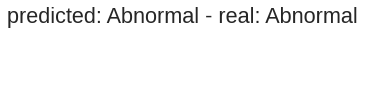

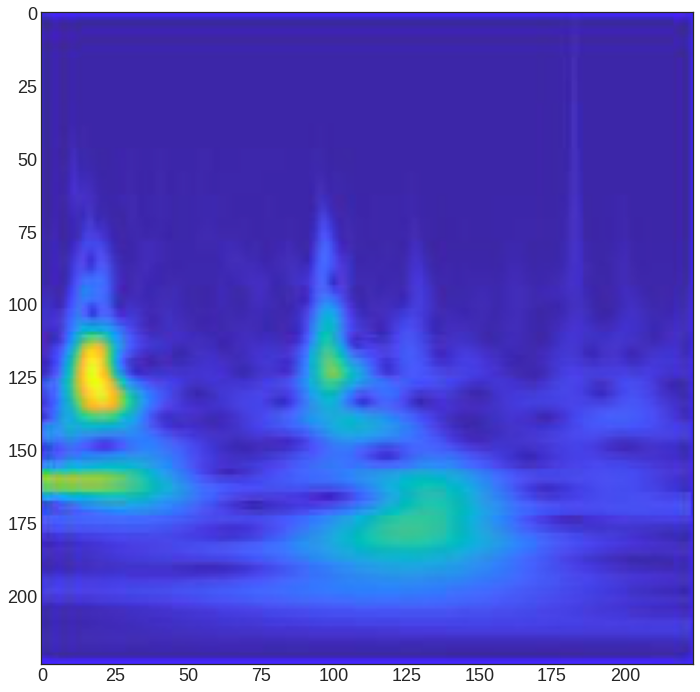

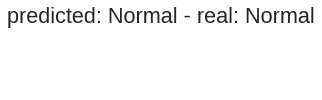

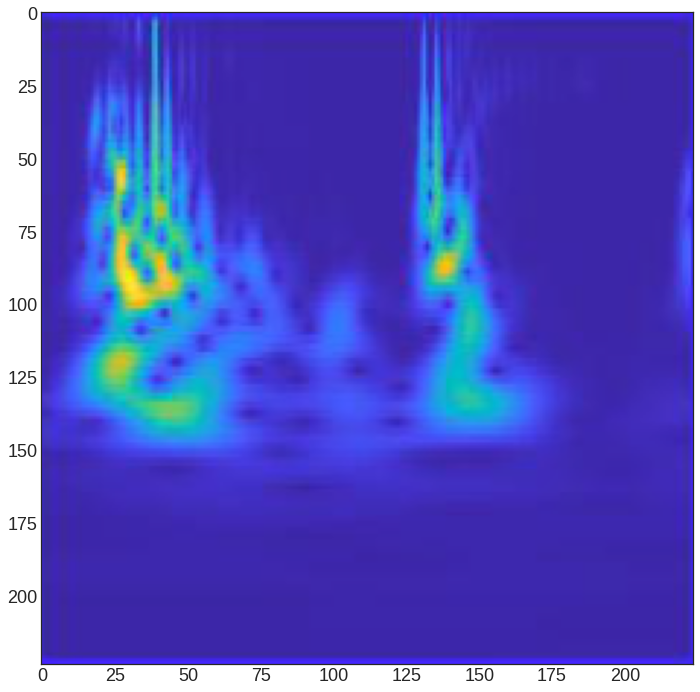

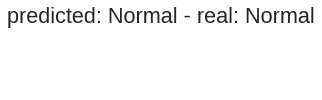

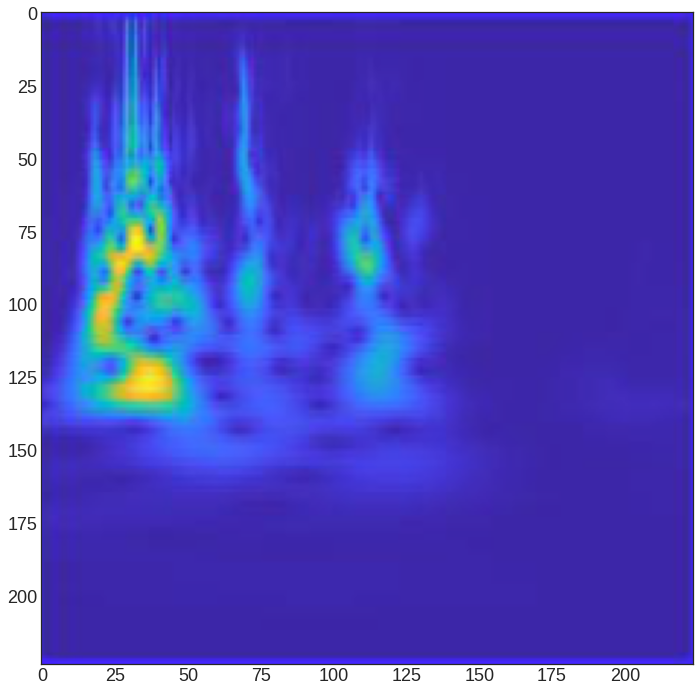

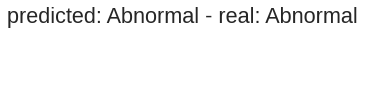

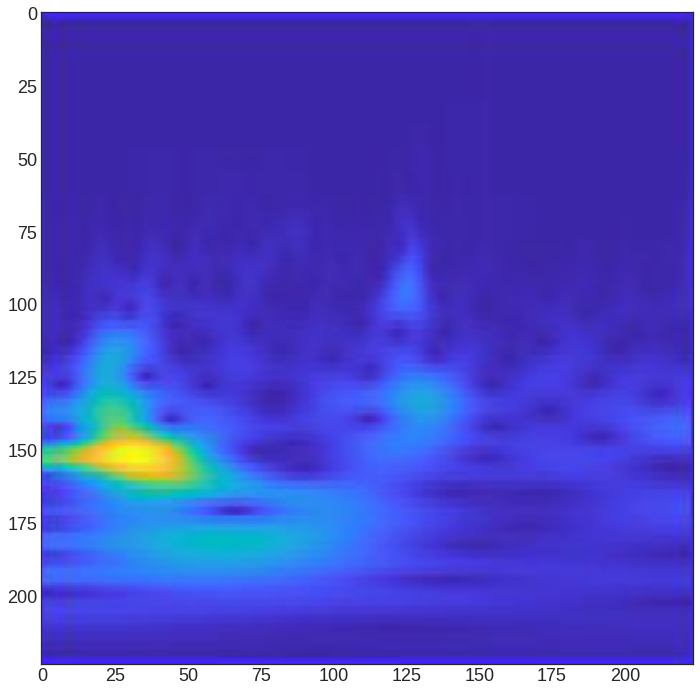

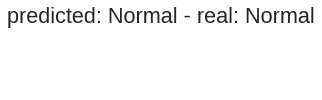

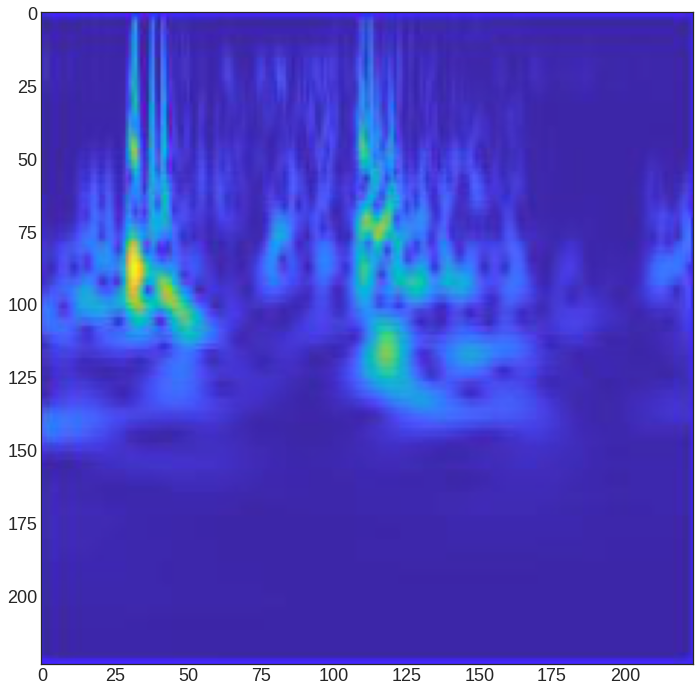

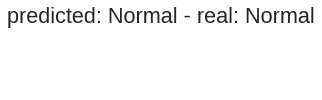

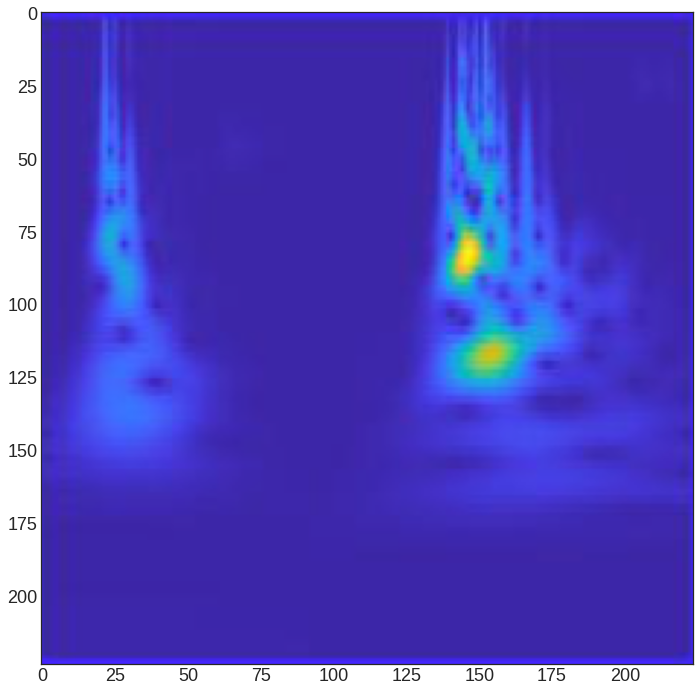

In [15]:
visualize_model(res_model, dataloaders, class_names)

## VGG16

In [37]:
vgg_model = models.vgg16(pretrained=True)
num_ftrs = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = nn.Linear(num_ftrs, 2)
vgg_model = vgg_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [40]:
num_epochs = 25
vgg_model, vgg_train_cost, vgg_train_acc, vgg_val_cost, vgg_val_acc = train_model(vgg_model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 196.7916779667139 Acc: 0.7270051508462104
val Loss: 54.112386494874954 Acc: 0.7902869757174393

Epoch 1/24
----------
train Loss: 161.33512773364782 Acc: 0.8013245033112583
val Loss: 49.665460616350174 Acc: 0.8167770419426048

Epoch 2/24
----------
train Loss: 142.65977830067277 Acc: 0.8263428991905813
val Loss: 41.3623296096921 Acc: 0.8498896247240618

Epoch 3/24
----------
train Loss: 128.80890323407948 Acc: 0.8410596026490066
val Loss: 37.745173029601574 Acc: 0.8543046357615894

Epoch 4/24
----------
train Loss: 103.445815814659 Acc: 0.8741721854304636
val Loss: 33.16400773334317 Acc: 0.8852097130242825

Epoch 5/24
----------
train Loss: 92.3162318977993 Acc: 0.8852097130242825
val Loss: 34.95609677536413 Acc: 0.8807947019867549

Epoch 6/24
----------
train Loss: 77.42991188593442 Acc: 0.9072847682119205
val Loss: 39.25889023259515 Acc: 0.8543046357615894

Epoch 7/24
----------
train Loss: 49.613690638158005 Acc: 0.9440765268579838
val Loss: 30.1052

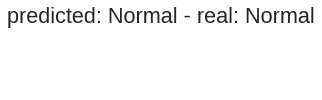

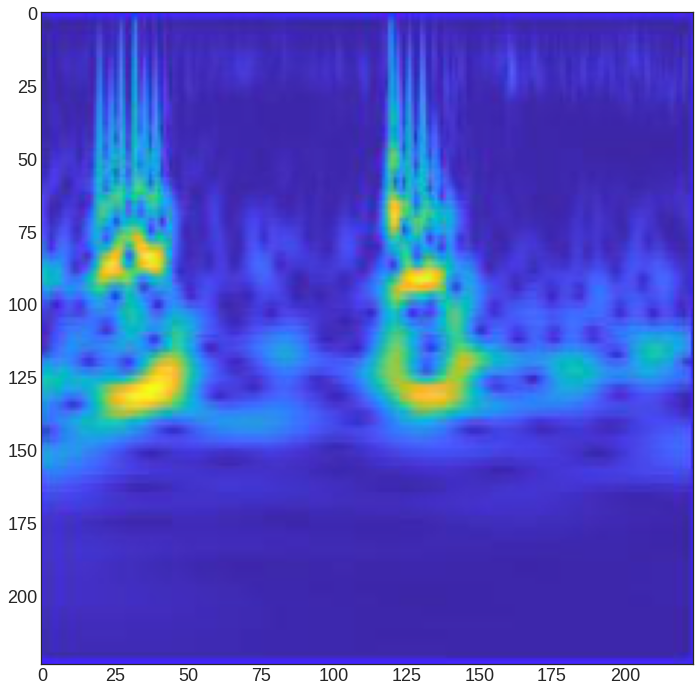

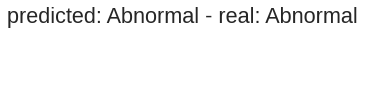

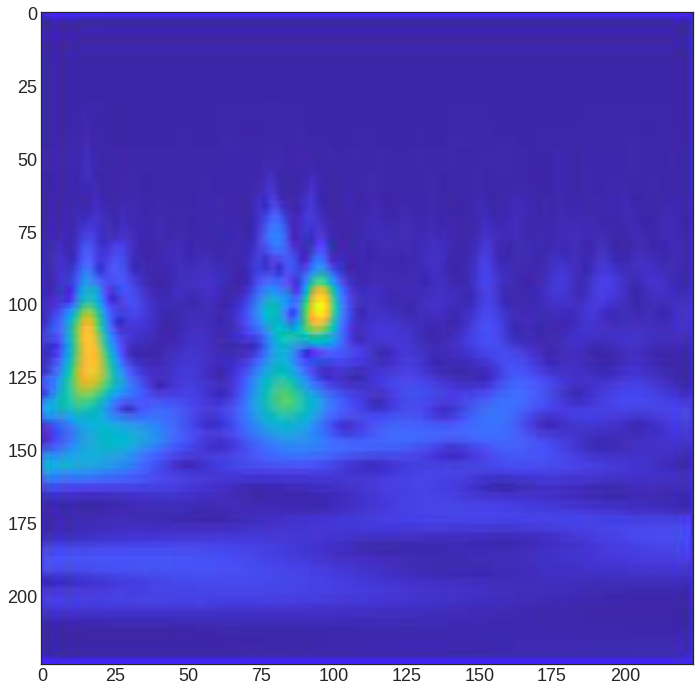

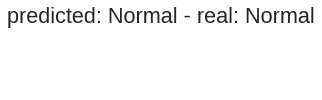

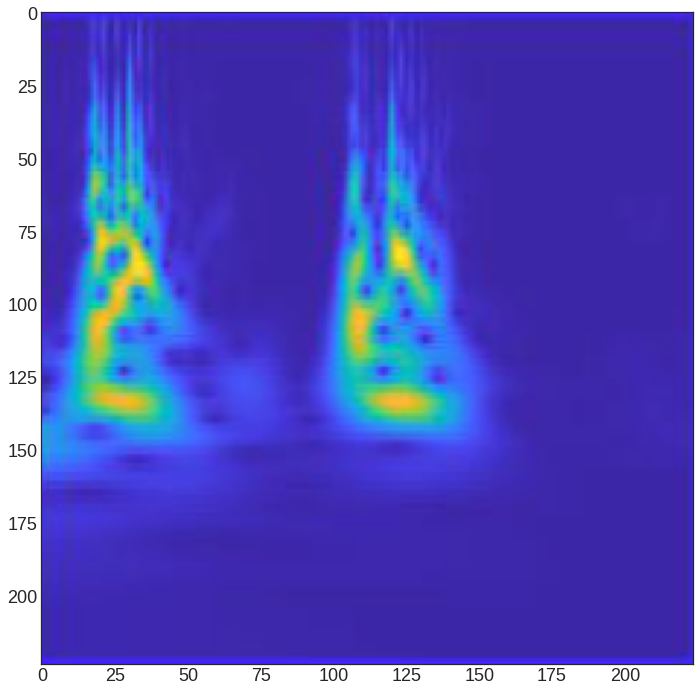

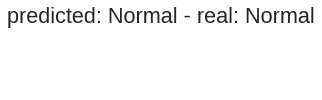

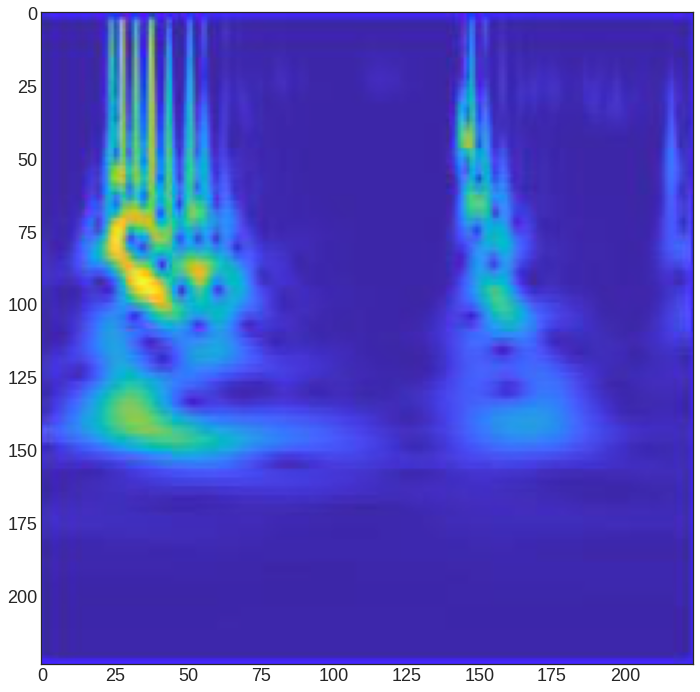

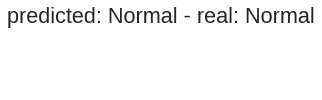

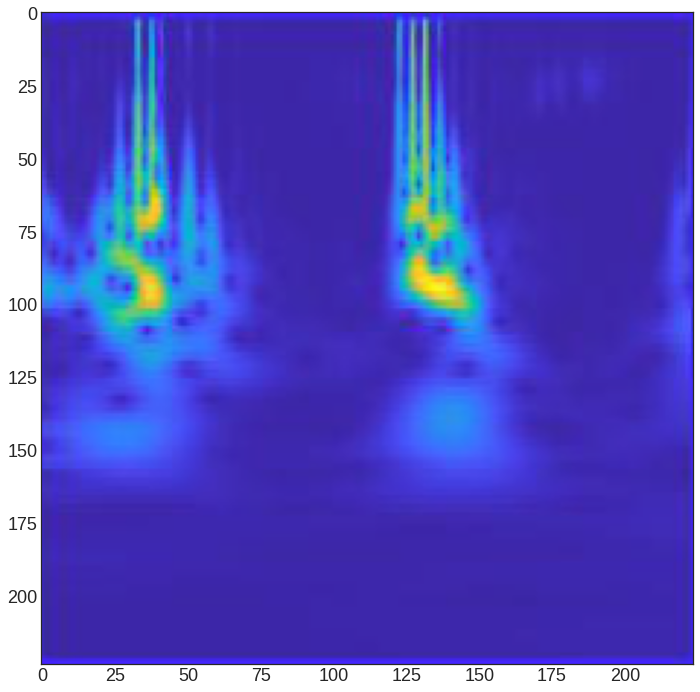

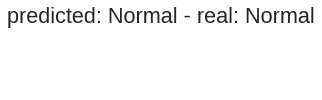

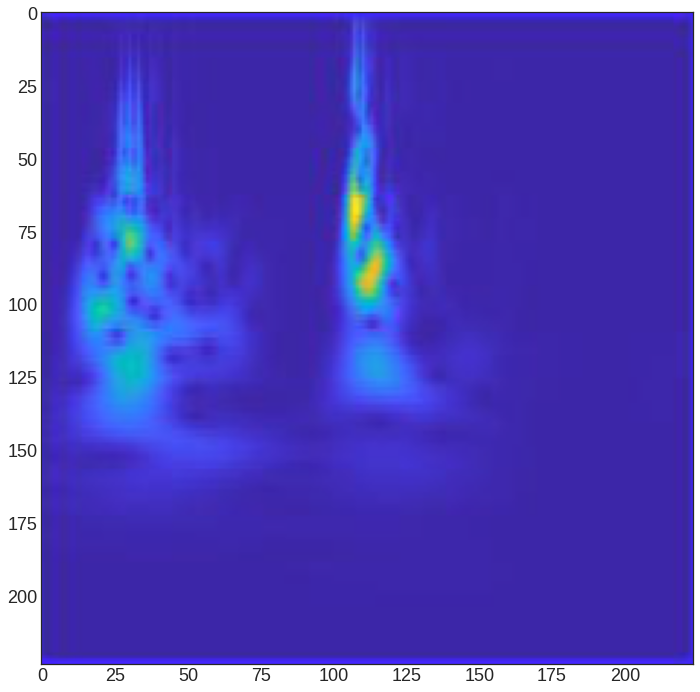

In [41]:
visualize_model(vgg_model, dataloaders, class_names)

## Curvas de aprendizaje

In [42]:
def plot_learning_curves(train_loss, train_acc, val_loss, val_acc, image_type, epochs):
    fig, ax = plt.subplots(2, 1, sharex='all', figsize=(10, 8))
    x = range(0, epochs)
    ax[0].set_title('Curvas de aprendizaje utilizando '+image_type)
    ax[0].plot(x, train_loss, '-+', label='training loss')
    ax[0].plot(x, val_loss, '-+', label='validation loss')
    ax[0].set_ylabel('loss')
    ax[0].grid(True)
    ax[0].legend()
    ax[1].plot(x, train_acc, '-+', label='training accuracy')
    ax[1].plot(x, val_acc, '-+', label='validation accuracy')
    ax[1].set_ylabel('accuracy')
    ax[1].grid(True)
    ax[1].legend()
    plt.show()

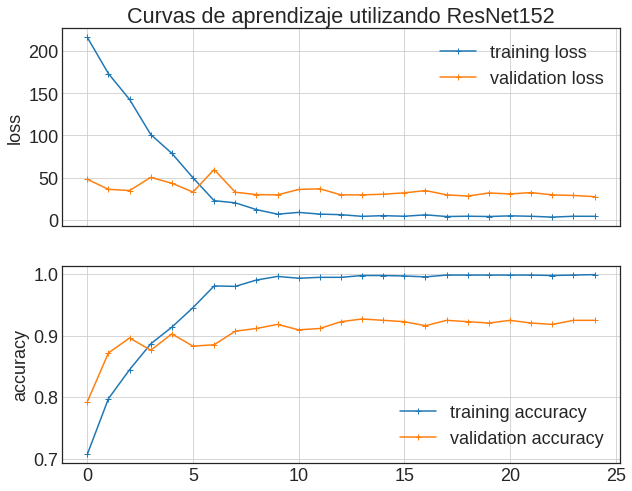

In [43]:
plot_learning_curves(train_cost, train_acc, val_cost, val_acc, 'ResNet152', num_epochs)

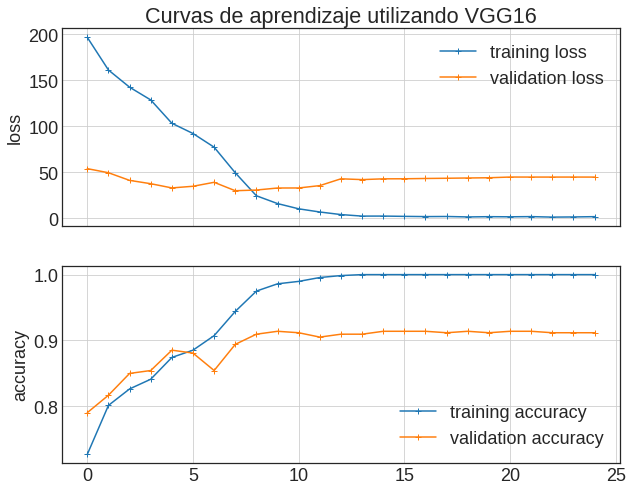

In [44]:
plot_learning_curves(vgg_train_cost, vgg_train_acc, vgg_val_cost, vgg_val_acc, 'VGG16', num_epochs)

## Prueba

In [51]:
def get_performance_measures(models, dataloader, dataset_sizes, class_names):
    accuracy_scores = {'ResNet152':0, 'VGG16':0}
    for model, cnn_type in zip(models, ['ResNet152', 'VGG16']):
        pred_labels = []
        test_labels = []
        running_corrects = 0
        for inputs, labels in dataloader['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds==labels.data)
            p = np.array(preds.cpu())
            l = np.array(labels.cpu())
            for x in range(p.size):
                pred_labels.append(p.item(x))
                test_labels.append(l.item(x))
        skplt.metrics.plot_confusion_matrix(test_labels, pred_labels, title=cnn_type, normalize=False)
        plt.show()
        test_acc = running_corrects.double()/dataset_sizes['test']
        accuracy_scores[cnn_type] = test_acc.cpu().data
    print(accuracy_scores)
    plt.figure(figsize=(6, 8))
    plt.bar(accuracy_scores.keys(), accuracy_scores.values())
    plt.ylabel('accuracy')
    plt.title('accuracy on test set')
    plt.grid(True)
    plt.show()
    return pred_labels, test_labels

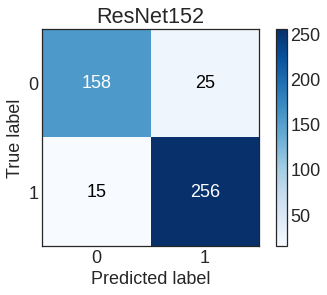

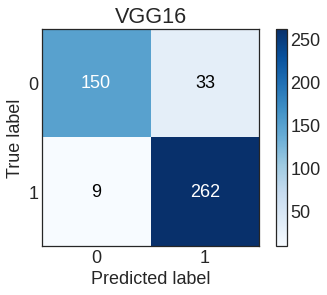

{'ResNet152': tensor(0.9119, dtype=torch.float64), 'VGG16': tensor(0.9075, dtype=torch.float64)}


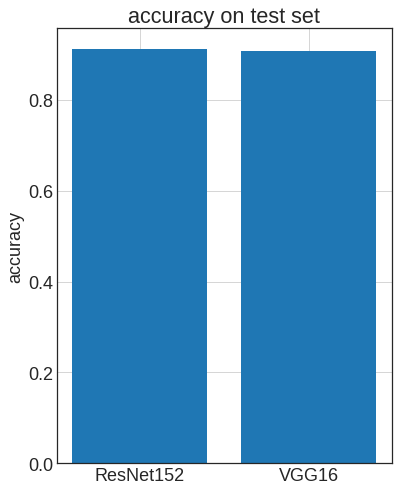

In [52]:
models = [res_model, vgg_model]
pred, test = get_performance_measures(models, dataloaders, dataset_sizes, class_names)